In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
import string
from datetime import datetime
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import maxabs_scale
import tensorflow as tf
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from sklearn.metrics import accuracy_score,f1_score
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mnssu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mnssu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnssu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data= pd.read_csv('fake reviews dataset.csv')

# Exploratory Data Analysis

In [3]:
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [5]:
data.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [6]:
data['category'].value_counts()

Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: category, dtype: int64

In [7]:
data['WordCount'] = [len(title.split()) for title in data['text_']]
data['UpperCaseCount'] = [sum(char.isupper() for char in title) for title in data['text_']]                           
data['SpecialCount'] = [sum(char in string.punctuation for char in title) for title in data['text_']]   

In [8]:
data.head(10)

,category,rating,label,text_,WordCount,UpperCaseCount,SpecialCount
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",12,4,5
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",16,1,3
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,14,2,2
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",17,2,2
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,18,3,2
5,Home_and_Kitchen_5,3.0,CG,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.,8,36,1
6,Home_and_Kitchen_5,5.0,CG,They are the perfect touch for me and the only...,19,2,1
7,Home_and_Kitchen_5,3.0,CG,These done fit well and look great. I love th...,17,2,1
8,Home_and_Kitchen_5,5.0,CG,"Great big numbers & easy to read, the only thi...",18,2,3
9,Home_and_Kitchen_5,5.0,CG,My son loves this comforter and it is very wel...,16,2,1


# Sentiment Analysis

In [9]:
sentanalyser = SentimentIntensityAnalyzer()

In [10]:
score = lambda title: sentanalyser.polarity_scores(title)['compound']
data['Sentiment'] = data['text_'].apply(score)

In [11]:
score=[]
for compound in data['Sentiment']:
  if compound >= 0:
    score.append(1)
  else:
    score.append(0)
data['Sentiment'] = score

In [12]:
def decontracted(phrase):    # This function decontract words like it's to it is.    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def cleanPunctuations(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
# Here, cleaning the data using functions define above, removing stopword and reducing words to there root words.

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
for sent in tqdm(data['text_']):
    filtered_sentence=[]
    
    sent = decontracted(sent)
    for w in sent.split():
        for cleaned_words in cleanPunctuations(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['Sentiment'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                    if (data['Sentiment'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

data["clean_review"] = final_string
data['clean_review']=data['clean_review'].str.decode("utf-8")

100%|██████████| 40432/40432 [00:38<00:00, 1041.96it/s]


In [14]:
print("review:",data['text_'][1],"\n")
print("*"*60)
print("\nclean_review:",data["clean_review"][1])
data[:5]

review: love it, a great upgrade from the original.  I've had mine for a couple of years 

************************************************************

clean_review: love great upgrad origin mine coupl year


,category,rating,label,text_,WordCount,UpperCaseCount,SpecialCount,Sentiment,clean_review
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",12,4,5,1,love well made sturdi comfort love itveri pretti
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",16,1,3,1,love great upgrad origin mine coupl year
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,14,2,2,1,pillow save back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",17,2,2,1,miss inform use great product price
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,18,3,2,1,nice set good qualiti set two month


Wordcloud of words present in positive class : 



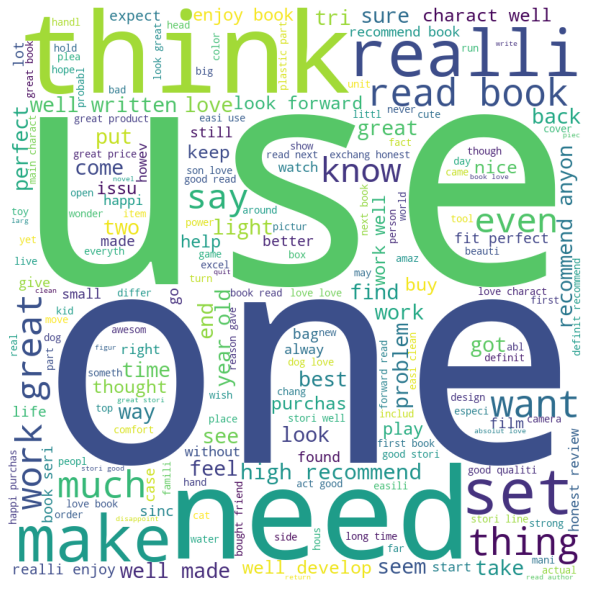

In [15]:
from wordcloud import WordCloud

print("Wordcloud of words present in positive class : \n")
wordcloud = WordCloud(width = 800, height = 800,background_color ='white', min_font_size = 10).generate(b' '.join(all_positive_words).decode("utf-8"))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Wordcloud of words present in negative class : 



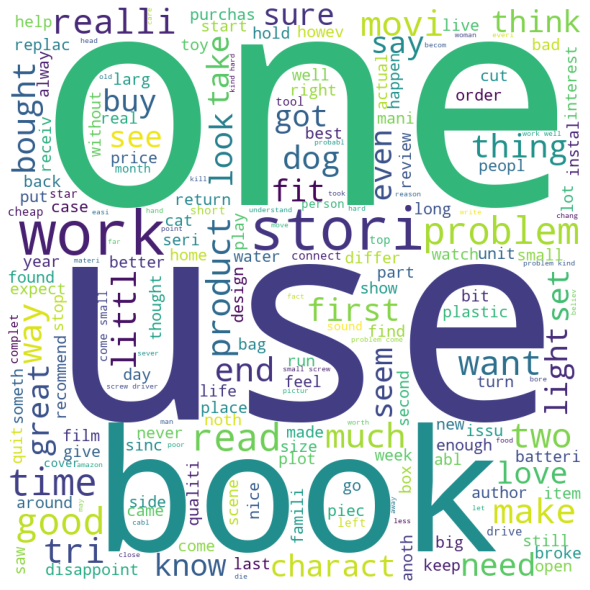

In [16]:
print("Wordcloud of words present in negative class : \n")
wordcloud = WordCloud(width = 800, height = 800,background_color ='white', min_font_size = 10).generate(b' '.join(all_negative_words).decode("utf-8"))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [17]:
data.shape

(40432, 9)

In [18]:
df_train = data[:40000]
df_test = data[40000:]
Y_train = df_train["Sentiment"].values
Y_test = df_test["Sentiment"].values

# Bag Of Words

In [19]:
word2count_train = {}
for data in df_train.clean_review: 
    words_train = nltk.word_tokenize(data) 
    for word in words_train: 
        if word not in word2count_train.keys(): 
            word2count_train[word] = 1
        else: 
            word2count_train[word] += 1
#print(word2count_train)

In [20]:
word2count_test = {} 
for data in df_test.clean_review: 
    words_test = nltk.word_tokenize(data) 
    for word in words_test: 
        if word not in word2count_test.keys(): 
            word2count_test[word] = 1
        else: 
            word2count_test[word] += 1
#print(word2count_test)

# TF-IDF

In [21]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 0.25, max_df = 1.0) #in scikit-learn
tf_idf_vect.fit(df_train.clean_review.values)    #fitting vectorizer on train data
tf_idf_train = tf_idf_vect.transform(df_train.clean_review.values)  #getting TFIDF on train data
tf_idf_test = tf_idf_vect.transform(df_test.clean_review.values)    ##getting TFIDF on test data
print("the shape of out text TFIDF vectorizer of train ",tf_idf_train.get_shape())
print("the shape of out text TFIDF vectorizer of test ",tf_idf_test.get_shape())

the shape of out text TFIDF vectorizer of train  (40000, 2)
the shape of out text TFIDF vectorizer of test  (432, 2)


# Data Preparation

In [22]:
del data

In [23]:
X_train = maxabs_scale(tf_idf_train)
X_test = maxabs_scale(tf_idf_test)
X_train.shape, X_test.shape

((40000, 2), (432, 2))

In [24]:
X_train = X_train.toarray().reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.toarray().reshape( X_test.shape[0], X_test.shape[1],1)
X_train.shape, X_test.shape

((40000, 2, 1), (432, 2, 1))

In [25]:
report= pd.DataFrame()

# Model Building

## ANN

In [26]:
now = datetime.now()

In [27]:
model = Sequential()
model.add(Input(shape=(2,)))

model.add(Dense(1, activation='tanh'))
print(model.output_shape)
print(model.compute_output_signature)
model.compile(loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

(None, 1)
<bound method Layer.compute_output_signature of <keras.engine.sequential.Sequential object at 0x0000023B221F4D00>>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train, Y_train, epochs=10, batch_size=1000)

Epoch 1/10
40/40 [==============================] - 1s 2ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 4/10
40/40 [==============================] - 0s 1ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 7/10
40/40 [==============================] - 0s 1ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 8/10
40/40 [==============================] - 0s 1ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 9/10
40/40 [==============================] - 0s 1ms/step - loss: 13.6993 - accuracy: 0.1119
Epoch 10/10
40/40 [==============================] - 0s 2ms/step - loss: 13.6993 - accuracy: 0.1119


In [29]:
predANN= np.round(model.predict(X_test))

In [30]:
acc= accuracy_score(Y_test, predANN)*100
acc

0.6944444444444444

In [31]:
f1= f1_score(Y_test, predANN, average='micro')*100
f1

0.6944444444444444

In [32]:
score= (model.evaluate(X_test, Y_test))
print(score)
time=(datetime.now()-now)
report= report.append([['ANN',acc,f1,time]])

14/14 [==============================] - 0s 1ms/step - loss: 15.2464 - accuracy: 0.0116
[15.246417999267578, 0.011574073694646358]


In [33]:
report

,0,1,2,3
0,ANN,0.694444,0.694444,0 days 00:00:16.674341


In [34]:
# save the model to disk
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("ann.h5")

## RNN

In [35]:
now = datetime.now()

In [36]:
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
print(model.output_shape)
print(model.compute_output_signature)
model.compile(loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

(None, 1)
<bound method Layer.compute_output_signature of <keras.engine.sequential.Sequential object at 0x0000023B29CE5AC0>>
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                192       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable par

In [37]:
model.fit(X_train, Y_train, epochs=5,batch_size=1000)

Epoch 1/5
40/40 [==============================] - 1s 5ms/step - loss: 1.0416 - accuracy: 0.6512
Epoch 2/5
40/40 [==============================] - 0s 4ms/step - loss: 0.3296 - accuracy: 0.8880
Epoch 3/5
40/40 [==============================] - 0s 4ms/step - loss: 0.3238 - accuracy: 0.8881
Epoch 4/5
40/40 [==============================] - 0s 4ms/step - loss: 0.3221 - accuracy: 0.8881
Epoch 5/5
40/40 [==============================] - 0s 4ms/step - loss: 0.3226 - accuracy: 0.8881


In [38]:
predRNN= np.round(model.predict(X_test))

In [39]:
acc= accuracy_score(Y_test,predRNN)*100
acc

98.8425925925926

In [40]:
f1= f1_score(Y_test,predRNN)*100
f1

99.41792782305005

In [41]:
time=(datetime.now()-now)
report= report.append([['RNN',acc,f1,time]])

In [42]:
report

,0,1,2,3
0,ANN,0.694444,0.694444,0 days 00:00:16.674341
0,RNN,98.842593,99.417928,0 days 00:00:14.672236


In [43]:
# save the model to disk
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("rnn.h5")

## Deep RNN

In [44]:
now = datetime.now()

In [45]:
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
print(model.output_shape)
print(model.compute_output_signature)
model.compile(loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

(None, 1)
<bound method Layer.compute_output_signature of <keras.engine.sequential.Sequential object at 0x0000023B29EFC730>>
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               768       
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0     

In [46]:
model.fit(X_train, Y_train)

1250/1250 [==============================] - 4s 3ms/step - loss: 0.3414 - accuracy: 0.8854


In [47]:
predDRNN= np.round(model.predict(X_test))

In [48]:
acc= accuracy_score(Y_test,np.round(predDRNN))*100
acc

98.8425925925926

In [49]:
f1= f1_score(Y_test,predDRNN)*100
f1

99.41792782305005

In [50]:
time=(datetime.now()-now)
report= report.append([['DRNN',acc,f1,time]])

In [51]:
report

,0,1,2,3
0,ANN,0.694444,0.694444,0 days 00:00:16.674341
0,RNN,98.842593,99.417928,0 days 00:00:14.672236
0,DRNN,98.842593,99.417928,0 days 00:00:27.382843


In [52]:
# save the model to disk
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("drnn.h5")

# Comparitive Analysis

In [53]:
report.columns= ['Model','Accuracy','F1-Score','Time']
report

,Model,Accuracy,F1-Score,Time
0,ANN,0.694444,0.694444,0 days 00:00:16.674341
0,RNN,98.842593,99.417928,0 days 00:00:14.672236
0,DRNN,98.842593,99.417928,0 days 00:00:27.382843


Text(0, 0.5, 'Accuracy Score')

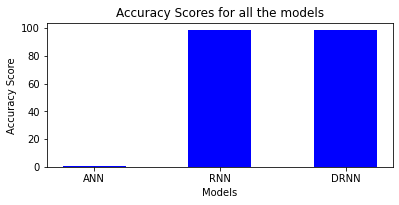

In [54]:
fig = plt.figure()
ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.bar(report['Model'], report['Accuracy'], color ='blue', width = 0.5) 
plt.title("Accuracy Scores for all the models")
plt.xlabel('Models')
plt.ylabel('Accuracy Score')


Text(0, 0.5, 'F1 Score')

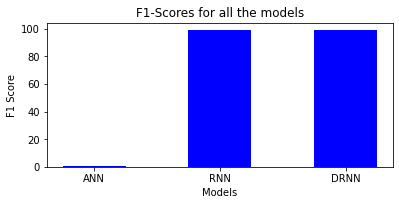

In [55]:
fig = plt.figure()
ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.bar(report['Model'], report['F1-Score'], color ='blue', width = 0.5) 
plt.title("F1-Scores for all the models")
plt.xlabel('Models')
plt.ylabel('F1 Score')


Text(0, 0.5, 'Time')

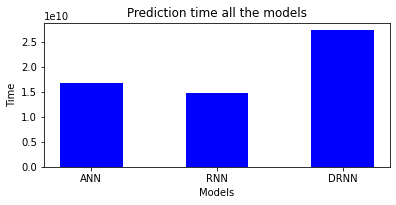

In [56]:
fig = plt.figure()
ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.bar(report['Model'], report['Time'], color ='blue', width = 0.5) 
plt.title("Prediction time all the models")
plt.xlabel('Models')
plt.ylabel('Time')


In [57]:
report

,Model,Accuracy,F1-Score,Time
0,ANN,0.694444,0.694444,0 days 00:00:16.674341
0,RNN,98.842593,99.417928,0 days 00:00:14.672236
0,DRNN,98.842593,99.417928,0 days 00:00:27.382843
